## 12.17_ÌîÑÎ°úÏ†ùÌä∏: CAMÏùÑ ÎßåÎì§Í≥† ÌèâÍ∞ÄÌï¥ Î≥¥Ïûê

In [8]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
import PIL
from PIL import Image
from tensorflow.keras import layers

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

2.6.0
1.21.4
4.5.3
8.3.2


### 2Í∞ÄÏßÄ Ïã§Ìóò ÏßÑÌñâÏùÑ Í≥ÑÌöç -> Îç∞Ïù¥ÌÑ∞Î•º ÏòÆÍ∏∞Îäî Í≥ºÏ†ïÏóêÏÑú ÏãúÍ∞ÑÏù¥ ÎßéÏù¥ ÏÜåÏöîÎêòÎäî Î¨∏Ï†ú.. => Ï∂îÌõÑ ÏßÑÌñâ
1. Diabetic Retinopathy Detection 
- Í¥ÄÏã¨ÏûàÎäî ÎãπÎá®Î≥ëÏÑ± ÎßùÎßâÎ≥ëÏ¶ù CAM, grad CAM Ïã§Ìóò ÏßÑÌñâ  
2. RSNA penumonia detectionÏùÄ bboxÏ°¥Ïû¨ iouÍ≥ÑÏÇ∞ Ïã§Ìóò

In [61]:
# # xray ÌèêÎ†¥ ÌÉêÏßÄ
# import tensorflow_datasets as tfds

# (ds_train, ds_test), ds_info = tfds.load(
#     'rsna_pneumonia_detection', 
#     split=['train', 'test'],
#     shuffle_files=True,
#     as_supervised=Fa„Ö†lse,  # Ïù¥ÎØ∏ÏßÄÏôÄ bounding boxÎ•º ÏÇ¨Ïö©
#     with_info=True
# )

# print(ds_info)

### 1. Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨ÏÑ± Î∞è Ï†ÑÏ≤òÎ¶¨

### ÎãπÎá®Î≥ëÏÑ± ÎßùÎßâÎ≥ëÏ¶ù Îç∞Ïù¥ÌÑ∞

CSV ÌååÏùº ÎÇ¥Ïö© ÌôïÏù∏:
      image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1

Ï¥ù 85Í∞úÏùò Ïù¥ÎØ∏ÏßÄ ÌååÏùº ÌôïÏù∏.
['19477_left.jpeg', '19441_right.jpeg', '111_left.jpeg', '19475_left.jpeg', '1943_right.jpeg']


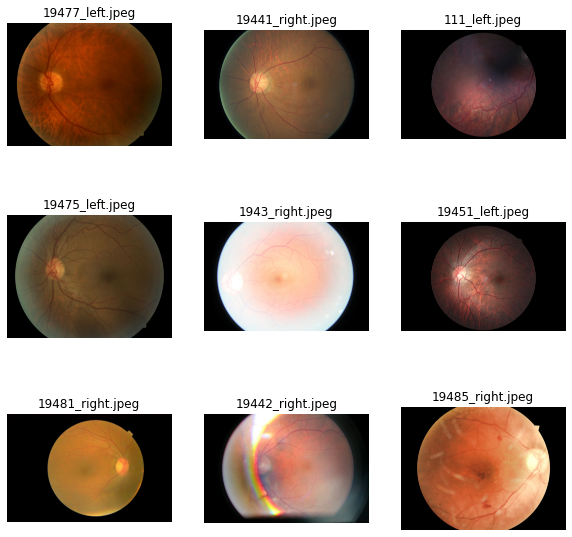

In [60]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Í≤ΩÎ°ú ÏÑ§Ï†ï
image_folder_path = '/aiffel/aiffel/workplace/12.07_CAM'
label_csv_path = '/aiffel/aiffel/workplace/12.07_CAM/12.17_DB_trainLabels.csv'

# ÎùºÎ≤®
label_df = pd.read_csv(label_csv_path)  
print("CSV ÌååÏùº ÎÇ¥Ïö© ÌôïÏù∏:")
print(label_df.head())

# Î™®Îì† JPEG ÌååÏùº Î∂àÎü¨Ïò§Í∏∞
image_files = [file for file in os.listdir(image_folder_path) if file.endswith(".jpeg")]
print(f"\nÏ¥ù {len(image_files)}Í∞úÏùò Ïù¥ÎØ∏ÏßÄ ÌååÏùº ÌôïÏù∏.")
print(image_files[:5])  # ÏùºÎ∂Ä ÌååÏùº Ï∂úÎ†•

# Ïù¥ÎØ∏ÏßÄ ÌôïÏù∏
def show_sample_images(image_folder, image_files, num_images=9):
    plt.figure(figsize=(10, 10))
    for i, image_name in enumerate(image_files[:num_images]):
        image_path = os.path.join(image_folder, image_name)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Failed to load image: {image_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.title(image_name)
        plt.axis("off")
    plt.show()

show_sample_images(image_folder_path, image_files)

- Ï¢åÏÉÅÎã®Î∂ÄÌÑ∞ ÏàúÏÑúÎåÄÎ°ú class 0 , 2, 0, / 0, 0, 1, / 0, 0, 2 
- Í∞Å classÎäî ÏßàÎ≥ëÏùò ÏßÑÌñâÏ†ïÎèÑÏôÄ Í¥ÄÎ†® ÏûàÏäµÎãàÎã§.
- ÎãπÏ¥à Î™©Ï†ÅÏùÄ, ÏúÑ ÎãπÎá®Î≥ëÏÑ± ÎßùÎßâÎ≥ëÏ¶ùÏùò Îç∞Ïù¥ÌÑ∞Îì§ÏùÑ Ïñ¥ÎñªÍ≤å ÏßàÎ≥ëÏùò ÏßÑÌñâÏ†ïÎèÑ(ÌÅ¥ÎûòÏä§ 0~4)Ïóê Îî∞Îùº Î∂ÑÎ•òÌïòÎäîÏßÄ CAMÏùÑ ÌÜµÌï¥ ÌôïÏù∏ÌïòÍ≥† Ïã∂ÏóàÏäµÎãàÎã§.
- ÌïòÏßÄÎßå Ïù¥ÎØ∏ÏßÄÎì§ Î∞è Í∞Å Ïù¥ÎØ∏ÏßÄÏóê Ìï¥ÎãπÌïòÎäî ÎùºÎ≤®ÏùÑ ÌôïÏù∏Ìïú Í≤∞Í≥º, ÏúÑ Îç∞Ïù¥ÌÑ∞ ÏñëÎßåÏúºÎ°úÎäî Ï∂©Î∂ÑÌïú ÌïôÏäµÏù¥ Ïñ¥Î†§Ïö∏ Í≤ÉÏù¥Îùº ÏÉùÍ∞ÅÏù¥ Îì§ÏóàÏäµÎãàÎã§. (ÏïΩ 80Í∞úÏù¥ÏÉÅÏùò Îç∞Ïù¥ÌÑ∞Î•º ÎÑ£ÎäîÍ≤ÉÎßå ÌïòÎçîÎùºÎèÑAiffel Ìè¥ÎçîÏóêÎäî ÏãúÍ∞ÑÏù¥ Ïò§Îûò Í±∏Î¶¨Îäî Î¨∏Ï†úÍ∞Ä ÏûàÏäµÎãàÎã§„Ö†)
- Ï∂îÌõÑ ÏãúÍ∞ÑÏù¥ ÎêúÎã§Î©¥, Ï¢ÄÎçî

### 2. ResNet50ÏùÑ ÌôúÏö©Ìïú CAM Î™®Îç∏ Íµ¨ÏÑ± Î∞è ÌïôÏäµ, Ï†ÅÏö©

In [7]:
# Normalize and resize
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
# Îç∞Ïù¥ÌÑ∞ÏÖãÏóê Ï†ÑÏ≤òÎ¶¨ÏôÄ Î∞∞ÏπòÏ≤òÎ¶¨Î•º Ï†ÅÏö©Ìï©ÎãàÎã§.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# Íµ¨ÏÑ±Îêú Î∞∞ÏπòÏùò Î™®ÏñëÏùÑ ÌôïÏù∏Ìï¥ Î¥ÖÎãàÎã§. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

In [ ]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet Î∂ÑÎ•òÍ∏∞  fully connected layer Ï†úÍ±∞
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAPÎ•º Ï†ÅÏö© -> Ïù¥ÎØ∏ ÏÇ¨Ï†ÑÏóê Global Average Pooling Î†àÏù¥Ïñ¥ Ï†ÅÏö©!
)
x = base_model.output

# Softmax ÌôúÏÑ±Ìôî Ìï®ÏàòÎ•º ÏÇ¨Ïö©Ìïú Fully Connected Layer Ï∂îÍ∞Ä # preds = ADD_YOUR_DENSE_LAYER(x)
preds = layers.Dense(num_classes, activation='softmax', name="predictions")(x) # ÌÅ¥ÎûòÏä§ ÏàòÏóê ÎßûÍ≤å Ï∂úÎ†• ÎÖ∏ÎìúÎ•º ÏÑ§Ï†ï

# ÏµúÏ¢Ö CAM Î™®Îç∏ ÏÉùÏÑ±
cam_model = keras.Model(inputs=base_model.input, outputs=preds)
Cam_model.summary()


In [ ]:
# get_one() Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑú ÌïúÏû•Ïãù ÎΩëÏùÑ Ïàò ÏûàÎèÑÎ°ù
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [ ]:
# 1. Ïù¥Î≤à ÎÖ∏ÎìúÏóê ÎÇòÏôîÎçò CAMÏùÑ ÏßÅÏ†ë Íµ¨ÌòÑÌï¥ Î¥ÖÏãúÎã§. ÏòàÏ†ú ÏΩîÎìúÎ•º ÏµúÎåÄÌïú Î≥¥ÏßÄ ÎßêÍ≥†, ÏÑ§Î™ÖÍ≥º Ïù¥Î°†ÏùÑ Î≥¥Í≥† Íµ¨ÌòÑÌï¥ Î≥¥ÏÑ∏Ïöî.
def generate_cam(model, item):
    cam_image = None
    # TODO: generate cam image
    return cam_image

In [ ]:
# 2. ÎßåÎì† Ìï®ÏàòÎ°ú CAM Ïù¥ÎØ∏ÏßÄÎ•º ÏÉùÏÑ±Ìï©ÏãúÎã§.
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)


In [ ]:
# 3. ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÏôÄ CAM Ïù¥ÎØ∏ÏßÄÎ•º ÏûÖÎ†•ÏúºÎ°ú Î∞õÍ≥† Îëê Í∞úÏùò Ïù¥ÎØ∏ÏßÄÏùò Ìà¨Î™ÖÎèÑÎ•º Ï°∞Ï†ï, ÌïòÎÇòÏùò Ïù¥ÎØ∏ÏßÄÏóêÏÑú ÏõêÎ≥∏Í≥º CAMÏùÑ Í≤πÏ≥ê Î≥¥Ïó¨Ï£ºÎäî visualize_cam_on_image() Ìï®ÏàòÎ•º ÎßåÎì§Ïñ¥Î≥¥ÏÑ∏Ïöî.
def visualize_cam_on_image(image, cam_image):
    # TODO: blend image
    merged_image = None
    return merged_image

# visualize_cam_on_image() Ìï®Ïàò ÏÇ¨Ïö©

type(item['image'].numpy())

origin_image = item['image'].numpy().astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)



### 3. Grad-CAM Íµ¨ÌòÑ Î∞è Ï†ÅÏö© 
Ïù¥Î≤à ÎÖ∏ÎìúÏóê ÎÇòÏôîÎçò Grad-CAMÏùÑ ÏßÅÏ†ë Íµ¨ÌòÑÌï¥ Î¥ÖÏãúÎã§. ÏòàÏ†ú ÏΩîÎìúÎ•º ÏµúÎåÄÌïú Î≥¥ÏßÄ ÎßêÍ≥†, ÏÑ§Î™ÖÍ≥º Ïù¥Î°†ÏùÑ Î≥¥Í≥† Íµ¨ÌòÑÌï¥ Î≥¥ÏÑ∏Ïöî.   

ÎßåÎì† Ìï®ÏàòÎ°ú Ïó¨Îü¨ Î†àÏù¥Ïñ¥Ïùò CAM Ïù¥ÎØ∏ÏßÄÎ•º ÎΩëÏïÑÏÑú ÏßÅÏ†ë ÌôïÏù∏Ìï¥ Î≥¥ÏÑ∏Ïöî.  

ÏúÑÏóêÏÑú ÎßåÎì† Ïù¥ÎØ∏ÏßÄ visualize_cam_on_image() Ìï®ÏàòÎ°ú Ïù¥ÎØ∏ÏßÄÎ•º ÏãúÍ∞ÅÌôîÌï¥ Î≥¥ÏÑ∏Ïöî.  

In [ ]:
def generate_grad_cam(model, activation_layer, item):
    grad_cam_image = None
    # TODO: generate grad_cam_image

    return grad_cam_image

### 4. Î∞îÏö¥Îî© Î∞ïÏä§ Íµ¨ÌïòÍ∏∞ 
1. Ï†úÏãúÎêú ÏΩîÎìúÎ•º Ï∞∏Í≥†Ìï¥, ÏßÅÏ†ë Grad-CAMÏúºÎ°ú ÏñªÏùÄ CAMÏùÑ ÌÜµÌï¥ÏÑú Î∞îÏö¥Îî© Î∞ïÏä§Î•º ÏñªÏñ¥Î≥¥ÏÑ∏Ïöî.  

2. 1)ÏóêÏÑú ÏñªÏùÄ Î∞îÏö¥Îî© Î∞ïÏä§Î•º ÏãúÍ∞ÅÌôîÌï¥ Î≥¥ÏÑ∏Ïöî.

### 5. IoU Íµ¨ÌïòÍ∏∞
Ï†ïÎãµ Î∞îÏö¥Îî© Î∞ïÏä§(ground truth) ÏôÄ ÏòàÏ∏°Í∞í Î∞îÏö¥Îî© Î∞ïÏä§(prediction box) Îëê Í∞ÄÏßÄÎ•º Ïù¥Ïö©Ìï¥ÏÑú IoUÎ•º Í≥ÑÏÇ∞ÌïòÎäî get_iou() Ìï®ÏàòÎ•º ÎßåÎì§Ïñ¥ Ï£ºÏÑ∏Ïöî.  

CAMÍ≥º Grad-CAMÏúºÎ°ú ÏñªÏùÄ Î∞îÏö¥Îî© Î∞ïÏä§ÏôÄ Ï†ïÎãµ Î∞îÏö¥Îî© Î∞ïÏä§ÏôÄÏùò IoUÎ•º Í∞ÅÍ∞Å ÎπÑÍµêÌï¥ Î¥ÖÏãúÎã§.  


In [ ]:
def get_iou(gt_bbox, pred_bbox):
    iou = None
    # TODO: get iou between two bbox
    return iou

### Î£®Î∏åÎ¶≠ 
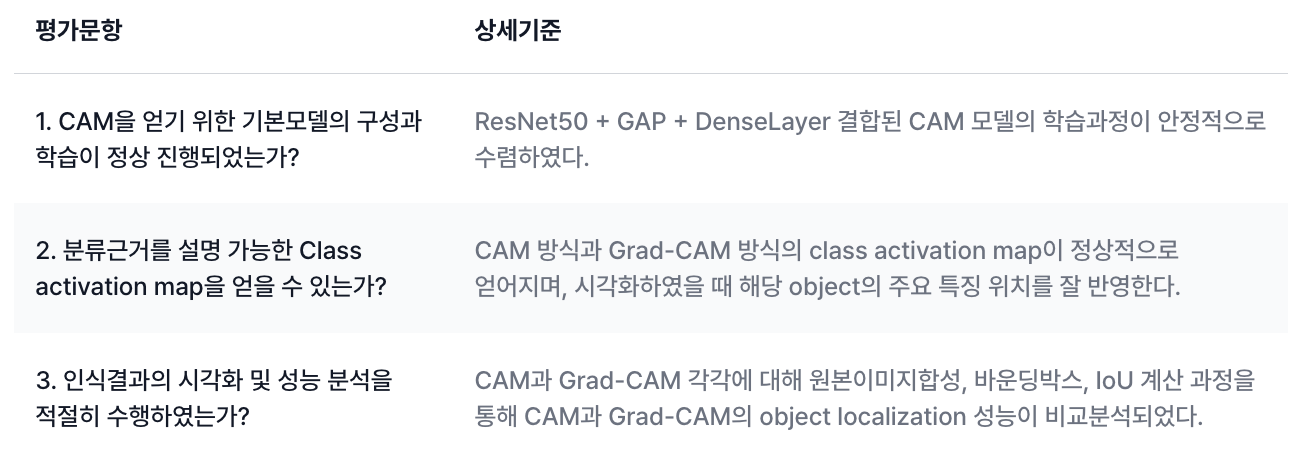

### 8-2. CAM, Grad-CAMÏö© Î™®Îç∏ Ï§ÄÎπÑÌïòÍ∏∞ (1) Îç∞Ïù¥ÌÑ∞ÏÖã Ï§ÄÎπÑÌïòÍ∏∞
CAM(Class Activation Map) ÏùÄ ÌäπÏÑ±ÏùÑ Ï∂îÏ∂úÌïòÎäî CNN ÎÑ§Ìä∏ÏõåÌÅ¨ Îí§Ïóê GAP(Global Average Pooling)ÏôÄ ÏÜåÌîÑÌä∏Îß•Ïä§ Î†àÏù¥Ïñ¥(softmax layer)Í∞Ä Î∂ôÎäî ÌòïÌÉúÎ°ú Íµ¨ÏÑ±ÎêòÏñ¥Ïïº ÌïúÎã§Îäî Ï†úÏïΩÏù¥ ÏûàÏäµÎãàÎã§. Î∞òÎ©¥Ïóê Grad-CAMÏùÄ Ïù¥Îü¨Ìïú Ï†úÏïΩÏù¥ ÏóÜÏ£†.

Ïù¥Î≤à ÏãúÍ∞ÑÏóêÎäî CAMÍ≥º Grad-CAM, Ïù¥ Îëê Í∞ÄÏßÄÎ•º Î™®Îëê Íµ¨ÌòÑÌï¥ Î≥¥Í≤†ÏäµÎãàÎã§.
Ïö∞ÏÑ† CAMÏùÑ ÏúÑÌïú Î™®Îç∏ÏùÑ Î®ºÏ†Ä Íµ¨ÏÑ±Ìï¥ Í∏∞Î≥∏Ï†ÅÏù∏ CAMÏùÑ Ï∂îÏ∂úÌï¥Î≥¥Í≥†, Ïù¥ Î™®Îç∏ÏóêÏÑú Grad-CAMÏùÑ ÌôúÏö©Ìï¥ Îã§Ïãú ÏãúÍ∞ÅÌôî Í≤∞Í≥ºÎ¨ºÏùÑ Ï∂îÏ∂úÌïòÍ≤†ÏäµÎãàÎã§. Grad-CAMÏùÄ Î™®Îç∏Ïùò Íµ¨Ï°∞Ïóê Ï†úÏïΩÏù¥ ÏóÜÍ∏∞ ÎïåÎ¨∏Ïóê CAMÏóêÎßå Î™®Îç∏ÏùÑ ÎßûÏ∂∞ÎèÑ Ï∂©Î∂ÑÌïòÍ∏∞ ÎïåÎ¨∏ÏûÖÎãàÎã§.

CAMÏùÄ ÌÅ¥ÎûòÏä§Ïóê ÎåÄÌïú ÌôúÏÑ±Ìôî Ï†ïÎèÑÎ•º ÎÇòÌÉÄÎÇ∏ ÏßÄÎèÑ ÏûÖÎãàÎã§. Îî∞ÎùºÏÑú Í∏∞Î≥∏Ï†ÅÏúºÎ°ú Ïö∞Î¶¨Ïùò Î™®Îç∏ÏùÄ Î∂ÑÎ•ò(classfication) Î•º ÏàòÌñâÌïòÎäî Î™®Îç∏Ïù¥Ïñ¥Ïïº Ìï©ÎãàÎã§. ÌïòÏßÄÎßå Ïö∞Î¶¨Ïùò ÏµúÏ¢Ö Î™©ÌëúÎäî Ïù¥ÎØ∏ÏßÄ ÎÇ¥ÏóêÏÑú ÌÅ¥ÎûòÏä§Í∞Ä ÌôúÏÑ±Ìôî Îêú ÏúÑÏπòÎ•º ÌôïÏù∏ÌïòÍ≥† Ïù¥Î•º Ï†ïÎãµÍ≥º ÎπÑÍµêÌïòÎäî Í≤ÉÏù¥ÎØÄÎ°ú ÏúÑÏπò Ï†ïÎ≥¥Í∞Ä Í∏∞Î°ùÎêú Îç∞Ïù¥ÌÑ∞Í∞Ä Ìï®Íªò ÏûàÏñ¥Ïïº Ìï©ÎãàÎã§.

Tensorflow DatasetsÏùò Ïπ¥ÌÉàÎ°úÍ∑∏ÏóêÏÑú Ïù¥Îü¨Ìïú Îç∞Ïù¥ÌÑ∞Î•º ÌôïÏù∏Ìï† Ïàò ÏûàÎäîÎç∞Ïöî. Ïó¨Í∏∞ÏÑúÎäî stanford_dogs Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÏÇ¨Ïö©ÌïòÍ≤†ÏäµÎãàÎã§. Ïù¥Îäî 120 Ï¢ÖÏùò Í∞úÎ•º ÏÇ¨ÏßÑÏúºÎ°ú ÌåêÎ≥ÑÌïòÎäî Î∂ÑÎ•ò Î¨∏Ï†ú Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú, ÎùºÎ≤®Ïù¥ ÏúÑÏπò Ï†ïÎ≥¥Ïù∏ Î∞îÏö¥Îî© Î∞ïÏä§(bounding box) Ï†ïÎ≥¥Î•º Ìè¨Ìï®ÌïòÍ≥† ÏûàÏäµÎãàÎã§. Í∑∏Îüº ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨ÏôÄ Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Ï§ÄÎπÑÌïòÍ≥† ÏãúÏûëÌïòÍ≤†ÏäµÎãàÎã§.

-> FeaturesDictÎ°ú Í∞êÏã∏Ï†∏ÏûàÍ≥†, 'image', 'image/filename', 'label', 'objects' Ï¥ù 4Í∞úÏùò keysÎ•º Í∞ÄÏßê.






In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('Ïäù=3')

Ïäù=3


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
# stanford_dogs Îç∞Ïù¥ÌÑ∞ÏÖãÏùÄ 12,000Ïû•Ïùò ÌïôÏäµÏö© Îç∞Ïù¥ÌÑ∞ÏÖãÍ≥º 8,580Ïû•Ïùò ÌèâÍ∞ÄÏö© Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú Íµ¨ÏÑ±ÎêòÏñ¥ÏûàÏäµÎãàÎã§. tfds.load()Î•º ÌôúÏö©Ìï¥ÏÑú Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Îã§Ïö¥Î°úÎìú Ìï¥Ï£ºÏÑ∏Ïöî.
# ÏµúÏ¥à ÏàòÌñâÏãúÏóêÎäî Îã§Ïö¥Î°úÎìúÍ∞Ä ÏßÑÌñâÎê©ÎãàÎã§. Ïò§Îûò Í±∏Î¶¥ Ïàò ÏûàÏúºÎãà Ïú†ÏùòÌï¥ Ï£ºÏÑ∏Ïöî.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('Ïäù=3')

Ïäù=3


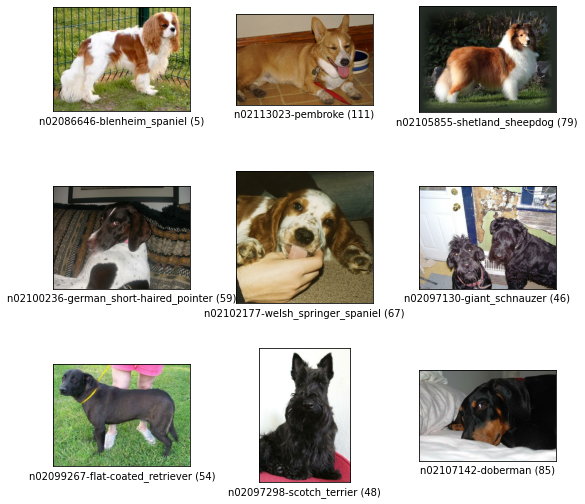

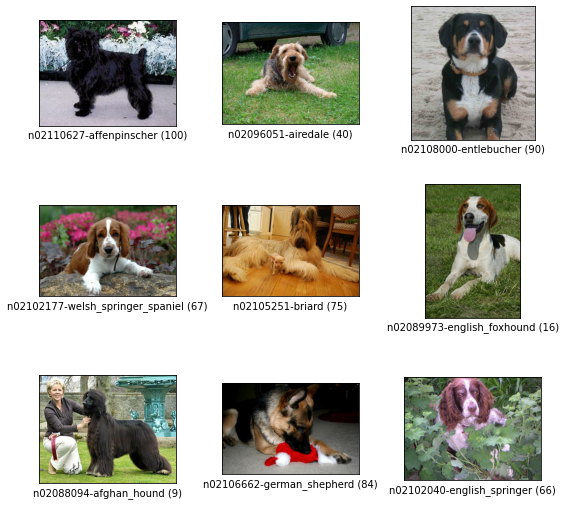

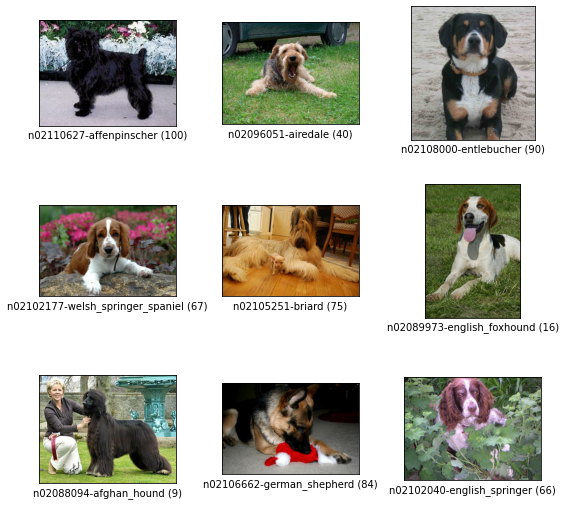

In [12]:
# tfds.show_examples() Î•º ÌÜµÌï¥ÏÑú Í∞Å Ïù¥ÎØ∏ÏßÄÏùò ÌÅ¥ÎûòÏä§ÏôÄ Í∑∏ Ïù∏Îç±Ïä§(index)Î•º ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.
tfds.show_examples(ds_train, ds_info)
tfds.show_examples(ds_test, ds_info)

### 8-3. CAM, Grad-CAMÏö© Î™®Îç∏ Ï§ÄÎπÑÌïòÍ∏∞ (2) Î¨ºÏ≤¥Ïùò ÏúÑÏπòÏ†ïÎ≥¥
ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ ÏúÑÏóê Î¨ºÏ≤¥Ïùò ÏúÑÏπòÏ†ïÎ≥¥Îäî Ïñ¥ÎñªÍ≤å ÏãúÍ∞ÅÌôîÌïòÏó¨ ÌëúÏãúÌï† Ïàò ÏûàÏùÑÍπåÏöî? Îç∞Ïù¥ÌÑ∞ÏÖãÏùò Î©îÌÉÄ Ï†ïÎ≥¥Ïù∏ df_infoÎ•º Ï°∞ÌöåÌï¥ featuresÍ∞Ä Ïñ¥ÎñªÍ≤å Íµ¨ÏÑ±ÎêòÏñ¥ ÏûàÎäîÏßÄ ÌôïÏù∏Ìï¥ Î¥ÖÏãúÎã§.






In [13]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

Î®ºÏ†Ä imageÏôÄ labelÏùÄ ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄÏôÄ Ïù¥ÎØ∏ÏßÄÏóê Ìï¥ÎãπÌïòÎäî Ï†ïÎãµ ÌÅ¥ÎûòÏä§Ïùò Ïù∏Îç±Ïä§ÏûÖÎãàÎã§. Î™á Î≤à Î≥¥Ïã† Ï†Å ÏûàÏúºÏã†Í∞ÄÏöî? Í∑∏Îü∞Îç∞ Ï°∞Í∏à ÏÉàÎ°úÏö¥ ÌÇ§(key)Í∞Ä ÏûàÏäµÎãàÎã§. bboxÎäî Î¨¥ÏóáÏùºÍπåÏöî? bbox(Î∞îÏö¥Îî© Î∞ïÏä§)Îäî ÏïÑÎûò Í∑∏Î¶ºÍ≥º Í∞ôÏù¥ Î¨ºÏ≤¥Ïùò ÏúÑÏπòÎ•º ÏÇ¨Í∞ÅÌòï ÏòÅÏó≠ÏúºÎ°ú ÌëúÍ∏∞ÌïòÎäî Î∞©Î≤ïÏûÖÎãàÎã§. ÏúÑÏóêÏÑú ÌôïÏù∏Ìïú Î∞îÎ°úÎäî BBoxFeatureÏù¥ÎùºÎäî ÌÉÄÏûÖÏúºÎ°ú Ï†ïÏùòÎêòÏñ¥ ÏûàÏäµÎãàÎã§.

Î∞îÏö¥Îî© Î∞ïÏä§Î•º ÌëúÏãúÌïòÎäî Î∞©Î≤ïÎì§
Î∞îÏö¥Îî© Î∞ïÏä§Î•º ÎùºÎ≤®ÎßÅÌïòÎäî Î∞©Î≤ïÏùÄ ÏïÑÏ£º Îã§ÏñëÌï©ÎãàÎã§. Í∑∏ Ï§ë Ï£ºÎ°ú ÏÇ¨Ïö©ÎêòÎäî Î∞©Î≤ïÏùÄ 'xywh' ÎòêÎäî 'minmax'Î°ú ÌëúÍ∏∞ÌïòÎäî Î∞©Î≤ïÏûÖÎãàÎã§.

'xywh' Îäî Î∞îÏö¥Îî©Î∞ïÏä§ Ï§ëÏã¨Ï†êÏùÑ x, yÎ°ú ÌëúÍ∏∞ÌïòÍ≥†, ÏÇ¨Í∞ÅÌòïÏùò ÎÑàÎπÑ wÏôÄ ÎÜíÏù¥ hÎ•º ÌëúÍ∏∞ÌïòÎäî Î∞©Î≤ïÏûÖÎãàÎã§.
(Ïòà) (x_center, y_center, width, height)
x, yÍ∞Ä Ï§ëÏã¨Ï†êÏù¥ ÏïÑÎãàÎùº Ï¢åÏ∏° ÏÉÅÎã®Ïùò Ï†êÏùÑ Í∞ÄÎ¶¨ÌÇ¨ ÏàòÎèÑ ÏûàÏäµÎãàÎã§.
'minmax'Îäî Î∞îÏö¥Îî©Î∞ïÏä§Î•º Ïù¥Î£®Îäî Ï¢åÌëúÏùò ÏµúÏÜåÍ∞íÍ≥º ÏµúÎåÄÍ∞íÏùÑ ÌÜµÌï¥ ÌëúÍ∏∞ÌïòÎäî Î∞©Î≤ïÏûÖÎãàÎã§.
(Ïòà) (x_min, x_max, y_min, y_max)
Ï¢åÌëúÏùò Ï†àÎåÄÍ∞íÏù¥ ÏïÑÎãàÎùº, Ï†ÑÏ≤¥ Ïù¥ÎØ∏ÏßÄÏùò ÎÑàÎπÑÏôÄ ÎÜíÏù¥Î•º Í∏∞Ï§ÄÏúºÎ°ú normalizeÌïú ÏÉÅÎåÄÏ†ÅÏù∏ Í∞íÏùÑ ÌëúÍ∏∞ÌïòÎäî Í≤ÉÏù¥ ÏùºÎ∞òÏ†ÅÏûÖÎãàÎã§.
ÏúÑ ÎëêÍ∞ÄÏßÄ ÎøêÎßå ÏïÑÎãàÎùº Ïù¥ÎØ∏ÏßÄÏùò ÏÉÅÌïòÏ¢åÏö∞ ÎÅùÎã®ÏúºÎ°úÎ∂ÄÌÑ∞ Í±∞Î¶¨Î°ú ÌëúÌòÑÌïòÎäî Î∞©Î≤ï, Ï¢åÏö∞Ï∏°Ïùò xÍ∞íÍ≥º ÏÉÅÌïòÏ∏°Ïùò yÍ∞í ÎÑ§ Í∞úÎ°ú ÌëúÏãúÌïòÎäî Î∞©Î≤ï(LRTB), ÎÑ§ Ï†êÏùò x, y Ï¢åÌëú Í∞íÏùÑ Î™®Îëê ÌëúÏãúÌïòÎäî Î∞©Î≤ï(QUAD) Îì± Ïó¨Îü¨ Í∞ÄÏßÄ Î∞©Î≤ïÏù¥ ÏûàÏäµÎãàÎã§. Îî∞ÎùºÏÑú ÏÉàÎ°úÏö¥ Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Ï†ëÌïòÍ±∞ÎÇò ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º ÌôúÏö©ÌïòÏã§ ÎïåÎäî Í∞ÑÎã®Ìïú Î∞îÏö¥Îî© Î∞ïÏä§ Ï†ïÎ≥¥ÎùºÎèÑ Ìïú Î≤à Îçî ÌëúÍ∏∞Î≤ïÏùÑ ÌôïÏù∏ÌïòÍ≥† ÎÑòÏñ¥Í∞ÄÎäî Í≤ÉÏù¥ Ï¢ãÏäµÎãàÎã§.

BBoxFeature

Q. Ï£ºÏñ¥ÏßÑ Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑú BBoxFeature ÌÉÄÏûÖÏúºÎ°ú ÌëúÍ∏∞Îêú bbox ÌïÑÎìúÎäî Ïñ¥Îñ§ Î∞©ÏãùÏúºÎ°ú Î∞îÏö¥Îî©Î∞ïÏä§Î•º ÎùºÎ≤®ÎßÅÌïòÍ≥† ÏûàÎÇòÏöî? ÏúÑÏóê Ï†úÏãúÎêú ÌÖêÏÑúÌîåÎ°úÏö∞ ÌäúÌÜ†Î¶¨Ïñº ÎßÅÌÅ¨Î•º ÌÜµÌï¥ ÌôïÏù∏Ìï¥ Î¥ÖÏãúÎã§.  
Ìï¥Îãπ bounding boxÎäî minmaxÎ•º ÏùòÎØ∏Ìï©ÎãàÎã§. tfdsÏùò Í≤ΩÏö∞ heightÎ•º Ï≤´Î≤àÏß∏ axisÎ°ú ÏÇºÍ≥†ÏûàÏñ¥ [ymin, xmin, ymax, xmax]Î•º ÏùòÎØ∏ÌïòÍ≤å Îê©ÎãàÎã§.








### 8-4. CAM, Grad-CAMÏö© Î™®Îç∏ Ï§ÄÎπÑÌïòÍ∏∞ (3) CAMÏùÑ ÏúÑÌïú Î™®Îç∏ ÎßåÎì§Í∏∞
Ïù¥Î≤àÏóêÎäî Î≥∏Í≤©Ï†ÅÏúºÎ°ú CAMÏùÑ ÏñªÏñ¥ÎÇ¥Í∏∞ ÏúÑÌïú Î™®Îç∏ÏùÑ ÎßåÎì§Ïñ¥ Î≥¥Í≤†ÏäµÎãàÎã§. ÎØ∏Î¶¨ Ïù¥ÎØ∏ÏßÄÎÑ∑(ImageNet) Îç∞Ïù¥ÌÑ∞Ïóê ÌõàÎ†®Îêú ResNet50ÏùÑ Í∏∞Î∞òÏúºÎ°ú ÌïòÍ≥†, Ïù¥ÌõÑ pooling layer Îí§Ïóê ÏÜåÌîÑÌä∏Îß•Ïä§ Î†àÏù¥Ïñ¥Î•º Î∂ôÏó¨ Grad-CAM Î™®Îç∏ÏùÑ ÎßåÎì§Í≤†ÏäµÎãàÎã§.

Ï∞∏Í≥†Î°ú, ÏÜåÌîÑÌä∏Îß•Ïä§ Î†àÏù¥Ïñ¥Îäî ÏÜåÌîÑÌä∏Îß•Ïä§ Ìï®ÏàòÎ•º ÌôúÏÑ±Ìôî Ìï®ÏàòÎ°ú ÏÇ¨Ïö©ÌïòÎäî fully connected Î†àÏù¥Ïñ¥ÏûÖÎãàÎã§.

Íµ¨ÌòÑÌï¥ Î≥¥Í∏∞
ÏïÑÎûòÏóêÏÑú ÏßÅÏ†ë ResNet50 Îí§Ïóê ÌïÑÏöîÌïú Î†àÏù¥Ïñ¥Î•º Î∂ôÏó¨ CAMÏùÑ Íµ¨ÌïòÍ∏∞ ÏúÑÌïú Í∏∞Î≥∏ Î™®Îç∏ÏùÑ ÏôÑÏÑ±Ìï¥ Ï£ºÏÑ∏Ïöî. CAM Î™®Îç∏Ïùò Íµ¨Ï°∞Í∞Ä ÏÉùÍ∞ÅÎÇòÏßÄ ÏïäÎäîÎã§Î©¥, Lecture ÎÖ∏ÎìúÎÇò Í¥ÄÎ†® ÎÇ¥Ïö©ÏùÑ Ï∞∏Í≥†Ìï¥ ÏôÑÏÑ±Ìï¥ Î≥¥ÏÑ∏Ïöî.






In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet Î∂ÑÎ•òÍ∏∞  fully connected layer Ï†úÍ±∞
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAPÎ•º Ï†ÅÏö© -> Ïù¥ÎØ∏ ÏÇ¨Ï†ÑÏóê Global Average Pooling Î†àÏù¥Ïñ¥ Ï†ÅÏö©!
)
x = base_model.output

# Softmax ÌôúÏÑ±Ìôî Ìï®ÏàòÎ•º ÏÇ¨Ïö©Ìïú Fully Connected Layer Ï∂îÍ∞Ä # preds = ADD_YOUR_DENSE_LAYER(x)
preds = layers.Dense(num_classes, activation='softmax', name="predictions")(x) # ÌÅ¥ÎûòÏä§ ÏàòÏóê ÎßûÍ≤å Ï∂úÎ†• ÎÖ∏ÎìúÎ•º ÏÑ§Ï†ï

# 4. ÏµúÏ¢Ö CAM Î™®Îç∏ ÏÉùÏÑ±
cam_model = keras.Model(inputs=base_model.input, outputs=preds)


CAM Î™®Îç∏ÏùÄ Ïö∞Î¶¨Í∞Ä Ìï¥ÏôîÎçò Î∂ÑÎ•ò Î¨∏Ï†úÎ•º ÏúÑÌïú Î™®Îç∏Í≥º ÌÅ¨Í≤å Îã§Î•∏ Ï†êÏù¥ ÏóÜÏäµÎãàÎã§. Îã§Îßå ÎßàÏßÄÎßâ fully connected layer ÎåÄÏã† GAPÏùÑ ÏÇ¨Ïö©Ìï¥Ï£ºÏñ¥Ïïº Ìï©ÎãàÎã§. Ïö∞Î¶¨Ïùò Í≤ΩÏö∞ ResNet50Ïùò Îß§Í∞úÎ≥ÄÏàò poolingÏóê 'avg'Î•º Îß§Í∞úÎ≥ÄÏàòÎ°ú Ï†ÑÎã¨Ìï®ÏúºÎ°úÏç® ÏâΩÍ≤å GAP Ïó∞ÏÇ∞ÏùÑ Î∂ôÏùº Ïàò ÏûàÏäµÎãàÎã§.



In [17]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

Q. CAMÏùÄ ÌäπÏÑ± Îßµ(feature map)ÏùÑ ÏÇ¨Ïö©Ìï¥ ÎßåÎì≠ÎãàÎã§. ÏúÑ Î†àÏù¥Ïñ¥Îì§ Ï§ë Ïö∞Î¶¨Í∞Ä ÏÇ¨Ïö©ÌïòÎäî ÌäπÏÑ± ÎßµÏùÄ Ïñ¥Îñ§ Î†àÏù¥Ïñ¥Ïùò Ï∂úÎ†•Í∞íÏùºÍπåÏöî? Ìï¥Îãπ Î†àÏù¥Ïñ¥Ïùò Ïù¥Î¶ÑÏùÑ Ï∞æÏïÑÎ≥¥ÏÑ∏Ïöî.  
conv5_block3_outÏùò outputÏù¥ feature mapÏù¥ Îê©ÎãàÎã§.   
Îî∞ÎùºÏÑú Ïù¥ feature mapÏóê Global average poolingÏùÑ ÌïòÏó¨ featureÏùò ÌÅ¨Í∏∞Î•º Ï§ÑÏù¥Í≥†, Ï§ÑÏñ¥Îì† feature Ï†ÑÏ≤¥Ïóê Dense layerÎ•º Î∂ôÏó¨ classificationÏùÑ ÏàòÌñâÌïòÍ≤å Îê©ÎãàÎã§.




### 8-5. CAM, Grad-CAMÏö© Î™®Îç∏ Ï§ÄÎπÑÌïòÍ∏∞ (4) CAM Î™®Îç∏ ÌïôÏäµÌïòÍ∏∞
Ïù¥Ï†ú ÌïôÏäµÏùÑ ÏúÑÌïú Í≥ºÏ†ïÏùÄ Ïù¥Ï†ÑÍ≥º ÎπÑÏä∑Ìï©ÎãàÎã§.

ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏôÄ Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞Ïóê normalizingÍ≥º resizingÏùÑ Ìè¨Ìï®Ìïú Í∞ÑÎã®Ìïú Ï†ÑÏ≤òÎ¶¨Î•º normalize_and_resize_img() ÏóêÏÑú ÏàòÌñâÌïòÎ©∞, Ïù¥Î•º Ìè¨Ìï®ÌïòÏó¨ apply_normalize_on_dataset()ÏóêÏÑú Î∞∞ÏπòÎ•º Íµ¨ÏÑ±Ìï©ÎãàÎã§.

inputÏóê Ïù¥Ï†ÑÍ≥º Îã§Î•¥Í≤å bbox Ï†ïÎ≥¥Í∞Ä Ìè¨Ìï®ÎêòÏñ¥ÏûàÏßÄÎßå, ÏßÄÍ∏à ÏàòÌñâÌï¥Ïïº Ìï† CAM Î™®Îç∏Ïùò ÌïôÏäµÏóêÎäî ÌïÑÏöîÍ∞Ä ÏóÜÏúºÎØÄÎ°ú normalize_and_resize_imgÍ≥ºÏ†ïÏóêÏÑú Ï†úÏô∏Ìï¥ Ï£ºÏóàÏäµÎãàÎã§. CAM Î™®Îç∏ÏùÄ object detectionÏù¥ÎÇò segmentationÏóêÎèÑ ÌôúÏö©Îê† Ïàò ÏûàÏßÄÎßå, bounding box Í∞ôÏùÄ ÏßÅÏ†ëÏ†ÅÏù∏ ÎùºÎ≤®ÏùÑ ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÍ≥† weakly supervised learningÏùÑ ÌÜµÌï¥ Î¨ºÏ≤¥ ÏòÅÏó≠ÏùÑ Í∞ÑÏ†ëÏ†ÅÏúºÎ°ú ÌïôÏäµÏãúÌÇ§Îäî Î∞©ÏãùÏù¥Í∏∞ ÎïåÎ¨∏ÏûÖÎãàÎã§.






In [20]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(                 # normalize_and_resize_img Ìï®ÏàòÎ•º Îç∞Ïù¥ÌÑ∞ÏÖã dsÏóê Î≥ëÎ†¨Î°ú Ï†ÅÏö©
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size) # Î∞∞ÏπòÏÇ¨Ïù¥Ï¶à ÎßåÌÅº Î¨∂Ïñ¥ÏÑú Î™®Îç∏Ïóê ÏûÖÎ†•
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE) # cpu gpu Î≥ëÎ†¨ÏûëÏóÖ, Ï†ÅÏ†àÌïú Î≤ÑÌçºÌÅ¨Í∏∞ ÏÑ§Ï†ï
    return ds

print('Ïäù=3')

Ïäù=3


In [21]:
# Îç∞Ïù¥ÌÑ∞ÏÖãÏóê Ï†ÑÏ≤òÎ¶¨ÏôÄ Î∞∞ÏπòÏ≤òÎ¶¨Î•º Ï†ÅÏö©Ìï©ÎãàÎã§.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# Íµ¨ÏÑ±Îêú Î∞∞ÏπòÏùò Î™®ÏñëÏùÑ ÌôïÏù∏Ìï¥ Î¥ÖÎãàÎã§. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


Ïù¥Ï†ú Î™®Îç∏ÏùÑ Ïª¥ÌååÏùºÌïòÍ≥† ÌïôÏäµÏãúÌÇµÏãúÎã§. Ïó¨Í∏∞ÏÑúÎäî ÎßõÎ≥¥Í∏∞Î°ú 2 Epoch Îßå ÌïôÏäµÏãúÏºú Î¥ÖÏãúÎã§.üòä (Îí∑ Î∂ÄÎ∂ÑÏóêÏÑúÎäî ÎØ∏Î¶¨ Ï§ÄÎπÑÌï¥Îëî ÌïôÏäµÎêú Í∞ÄÏ§ëÏπòÎ•º Î∂àÎü¨ÏôÄÏÑú Î™®Îç∏Ïóê Ï†ÅÏö©Ìï† ÏòàÏ†ïÏûÖÎãàÎã§.)






In [22]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

print('Ïäù=3')

Ïäù=3


In [23]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/2
750/750 [==============================] - 202s 203ms/step - loss: 2.2287 - accuracy: 0.4396 - val_loss: 3.3503 - val_accuracy: 0.2248
Epoch 2/2
750/750 [==============================] - 153s 204ms/step - loss: 0.6228 - accuracy: 0.8365 - val_loss: 1.1437 - val_accuracy: 0.6631


In [24]:
# Q. '/aiffel/class_activation_map' Ïóê 'cam_model1.h5'ÏùÑ Ï†ÄÏû•ÌïòÏÑ∏Ïöî.

import os

cam_model_path = '/aiffel/aiffle/workplace/12.07_CAM/cam_model1.h5'

# [[YOUR CODE]]
cam_model.save(cam_model_path) # modelÏùò Íµ¨Ï°∞, Í∞ÄÏ§ëÏπò, ÏòµÌã∞ÎßàÏù¥Ï†Ä ÏÉÅÌÉúÍπåÏßÄ Ìè¨Ìï®Ìï¥ÏÑú Ï†ÄÏû•

print(f"Î™®Îç∏Ïù¥ {cam_model_path}Ïóê ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.")

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Î™®Îç∏Ïù¥ /aiffel/aiffle/workplace/12.07_CAM/cam_model1.h5Ïóê ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Ï†ÄÏû•ÎêòÏóàÏäµÎãàÎã§.


### 8-6. CAM
Ïù¥Ï†ú ÌïôÏäµÎêú Î™®Îç∏ÏùÑ ÌôúÏö©ÌïòÏó¨ CAMÏùÑ ÏÉùÏÑ±Ìï¥ Î≥º Í≤ÉÏûÖÎãàÎã§. Î©îÎ™®Î¶¨ Î∂ÄÏ°±ÏúºÎ°ú Ïù∏Ìï¥ Ïù¥ÌõÑ Ïã§ÏäµÏóê Î¨∏Ï†úÍ∞Ä Î∞úÏÉùÌï† Ïàò ÏûàÏúºÎØÄÎ°ú, Ïù¥Î≤à Ïä§ÌÖù ÏãúÏûë Ï†ÑÏóê Ïª§ÎÑêÏùÑ Ïû¨ÏãúÏûëÌï† Í≤ÉÏùÑ Í∂åÌï©ÎãàÎã§.






In [25]:
# Ïª§ÎÑê Ïû¨ÏãúÏûë Ïù¥ÌõÑ Ïã§ÏäµÏùÑ ÏúÑÌï¥, Ïù¥Ï†Ñ Ïä§ÌÖùÏùò ÏΩîÎìúÎ•º Î™®ÏïÑÏÑú ÌïúÍ∫ºÎ≤àÏóê Ïã§ÌñâÌï©ÎãàÎã§.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('Ïäù=3')

Ïäù=3


Ïù¥Ï†ú ÌïôÏäµÎêú Î™®Îç∏ÏóêÏÑú CAMÏùÑ ÏÉùÏÑ±Ìï¥ Î¥ÖÏãúÎã§. CAM ÏÉùÏÑ± ÏûëÏóÖÏùÄ Îç∞Ïù¥ÌÑ∞ÏÖã Î∞∞Ïπò Îã®ÏúÑÍ∞Ä ÏïÑÎãàÎùº Í∞úÎ≥Ñ Ïù¥ÎØ∏ÏßÄ Îç∞Ïù¥ÌÑ∞ Îã®ÏúÑÎ°ú Ïù¥Î£®Ïñ¥ÏßÄÍ∏∞ ÎïåÎ¨∏Ïóê, get_one() Ìï®ÏàòÎ°ú Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑú Ìïú Ïû•Ïî© ÎΩëÏùÑ Ïàò ÏûàÎèÑÎ°ù ÌñàÏäµÎãàÎã§.






In [26]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('Ïäù=3')

Ïäù=3


67


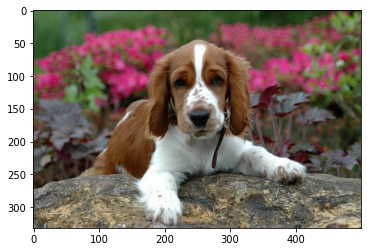

In [27]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [29]:
import os
cam_model_path = '/aiffel/aiffle/workplace/12.07_CAM/cam_model1.h5'
cam_model = tf.keras.models.load_model(cam_model_path)
print('Ïäù=3')

Ïäù=3


#### Ïù¥Ï†ú Îç∞Ïù¥ÌÑ∞Í∞Ä Ï§ÄÎπÑÎêòÏóàÏúºÎãà CAMÏùÑ ÏÉùÏÑ±ÌïòÍ∏∞ ÏúÑÌï¥ ÎØ∏Î¶¨ Ï§ÄÎπÑÎêú ÌïôÏäµÌïú Î™®Îç∏ÏùÑ Î∂àÎü¨ÏôÄ Î¥ÖÏãúÎã§.

    CAMÏùÑ ÏÉùÏÑ±ÌïòÍ∏∞ ÏúÑÌï¥ÏÑúÎäî (1) ÌäπÏÑ± Îßµ, 
    (2) ÌÅ¥ÎûòÏä§Î≥Ñ ÌôïÎ•†ÏùÑ ÏñªÍ∏∞ ÏúÑÌïú ÏÜåÌîÑÌä∏Îß•Ïä§ Î†àÏù¥Ïñ¥Ïùò Í∞ÄÏ§ëÏπò, Í∑∏Î¶¨Í≥† 
    (3) ÏõêÌïòÎäî ÌÅ¥ÎûòÏä§Ïùò Ï∂úÎ†•Í∞íÏù¥ ÌïÑÏöîÌï©ÎãàÎã§. 
    Îòê Ïù¥ÎØ∏ÏßÄÏóêÏÑú Î™®Îç∏Ïù¥ Ïñ¥Îñ§ Î∂ÄÎ∂ÑÏùÑ Î≥¥ÎäîÏßÄ ÏßÅÍ¥ÄÏ†ÅÏúºÎ°ú ÌôïÏù∏ÌïòÎ†§Î©¥ ÎÑ§Ìä∏ÏõåÌÅ¨ÏóêÏÑú ÎÇòÏò® CAMÏùÑ ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ï¶àÏôÄ Í∞ôÍ≤å ÎßåÎì§Ïñ¥ Ìï®Íªò ÏãúÍ∞ÅÌôîÌï¥Ïïº Ìï† Í≤ÉÏûÖÎãàÎã§. 
    Ïù¥Î•º Í≥†Î†§Ìï¥ÏÑú modelÍ≥º itemÏùÑ Î∞õÏïòÏùÑ Îïå ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄÏôÄ ÎèôÏùºÌïú ÌÅ¨Í∏∞Ïùò CAMÏùÑ Î∞òÌôòÌïòÎäî Ìï®ÏàòÎ•º ÎßåÎì§Ïñ¥Ïïº Ìï©ÎãàÎã§.

    generate_cam() ÏùÑ Íµ¨ÌòÑÌïòÍ∏∞ ÏúÑÌï¥ ÏïÑÎûòÏóêÏÑúÎäî conv_ouputsÏôÄ Í∞ôÏù¥ ÌäπÏ†ï Î†àÏù¥Ïñ¥Ïùò Í≤∞Í≥ºÍ∞íÏùÑ outputÏúºÎ°ú Î∞õÍ∏∞ ÏúÑÌï¥ ÏÉàÎ°úÏö¥ Î™®Îç∏ÏùÑ Ï†ïÏùòÌïòÍ≥†, 
    feedforwardÎ•º Í±∞Ïπú ÌõÑ CAMÏùÑ Í≥ÑÏÇ∞ÌïòÎèÑÎ°ù Íµ¨ÌòÑÌïòÏòÄÏäµÎãàÎã§. 
    ÎßàÏßÄÎßâÏóêÎäî ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄÏùò ÌÅ¨Í∏∞Ïóê ÎßûÏ∂∞ CAMÏùÑ resizeÌï¥ Ï£ºÏóàÏäµÎãàÎã§.

In [30]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # ÌïôÏäµÌïú Î™®Îç∏ÏóêÏÑú ÏõêÌïòÎäî LayerÏùò outputÏùÑ ÏñªÍ∏∞ ÏúÑÌï¥ÏÑú Î™®Îç∏Ïùò inputÍ≥º outputÏùÑ ÏÉàÎ°≠Í≤å Ï†ïÏùòÌï¥Ï§çÎãàÎã§.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    # model.layers[-3].output: ÎßàÏßÄÎßâÏóêÏÑú ÏÑ∏ Î≤àÏß∏ Î†àÏù¥Ïñ¥(Conv Î†àÏù¥Ïñ¥)Ïùò Ï∂úÎ†• (dens,pooling Ï†Ñ!=GAPÏù¥Ï†Ñ Conv Î†àÏù¥Ïñ¥Ïùò ÏïÑÏõÉÌíã)
    # tf.expand_dims(img_tensor, 0): Î∞∞Ïπò Ï∞®ÏõêÏùÑ Ï∂îÍ∞ÄÌï©ÎãàÎã§. ÏûÖÎ†• ÌòïÌÉúÎäî (1, height, width, channels)Í∞Ä Îê©ÎãàÎã§.
    # predictions: Î™®Îç∏Ïùò ÏµúÏ¢Ö ÌÅ¥ÎûòÏä§ ÏòàÏ∏° ÌôïÎ•†.
    # conv_outputs: Conv Î†àÏù¥Ïñ¥Ïùò Ï∂úÎ†• Feature Map.
    
    
    # Î™®Îç∏Ïùò weight activationÏùÄ ÎßàÏßÄÎßâ layerÏóê ÏûàÏäµÎãàÎã§. CAM Í≥ÑÏÇ∞ Ï§ÄÎπÑ
    class_weights = model.layers[-1].get_weights()[0] 
    # model.layers[-1]: ÏµúÏ¢Ö Dense Î†àÏù¥Ïñ¥Ïùò Í∞ÄÏ§ëÏπòÎ•º Í∞ÄÏ†∏Ïò§Í∏∞
    
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2]) # height,width
    for i, w in enumerate(class_weights[:, class_idx]):
        # class_weights[:, class_idx]: ÌäπÏ†ï ÌÅ¥ÎûòÏä§(class_idx)Ïùò Í∞ÄÏ§ëÏπòÎ•º Í∞ÄÏ†∏ÏòµÎãàÎã§.
        # conv_outputsÏùò iÎ≤àÏß∏ Ï±ÑÎÑêÍ≥º iÎ≤àÏß∏ weight(w)Î•º Í≥±Ìï¥ÏÑú ÎàÑÏ†ÅÌïòÎ©¥ ÌôúÏÑ±ÌôîÎêú Ï†ïÎèÑ(Í∞ïÎèÑ Í≥ÑÏÇ∞)Í∞Ä ÎÇòÌÉÄÎÇ† Í≤ÅÎãàÎã§.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation scoreÎ•º normalizeÌï©ÎãàÎã§. 0~1Î°ú Ïä§ÏºÄÏùºÎßÅ
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # ÏõêÎûò Ïù¥ÎØ∏ÏßÄÏùò ÌÅ¨Í∏∞Î°ú resizeÌï©ÎãàÎã§.
    return cam_image

"""
1. ÏúÑÏΩîÎìúÎ°ú ÌäπÏ†ï ÌÅ¥ÎûòÏä§Ïùò ÌôúÏÑ±Ìôî Îßµ(CAM)Ïù¥ ÏÉùÏÑ±
2. CAMÏùÄ Ïù¥ÎØ∏ÏßÄ ÎÇ¥ÏóêÏÑú Ìï¥Îãπ ÌÅ¥ÎûòÏä§ÏôÄ Í¥ÄÎ†®Îêú ÏòÅÏó≠ Í∞ïÏ°∞
3. Ïù¥Î•º ÌÜµÌï¥ Î™®Îç∏Ïù¥ Ïñ¥Îñ§ Î∂ÄÎ∂ÑÏùÑ Î≥¥Í≥† ÌäπÏ†ï ÌÅ¥ÎûòÏä§Î•º ÏòàÏ∏°ÌñàÎäîÏßÄ ÌôïÏù∏ Í∞ÄÎä•
"""

'\n1. ÏúÑÏΩîÎìúÎ°ú ÌäπÏ†ï ÌÅ¥ÎûòÏä§Ïùò ÌôúÏÑ±Ìôî Îßµ(CAM)Ïù¥ ÏÉùÏÑ±\n2. CAMÏùÄ Ïù¥ÎØ∏ÏßÄ ÎÇ¥ÏóêÏÑú Ìï¥Îãπ ÌÅ¥ÎûòÏä§ÏôÄ Í¥ÄÎ†®Îêú ÏòÅÏó≠ Í∞ïÏ°∞\n3. Ïù¥Î•º ÌÜµÌï¥ Î™®Îç∏Ïù¥ Ïñ¥Îñ§ Î∂ÄÎ∂ÑÏùÑ Î≥¥Í≥† ÌäπÏ†ï ÌÅ¥ÎûòÏä§Î•º ÏòàÏ∏°ÌñàÎäîÏßÄ ÌôïÏù∏ Í∞ÄÎä•\n'

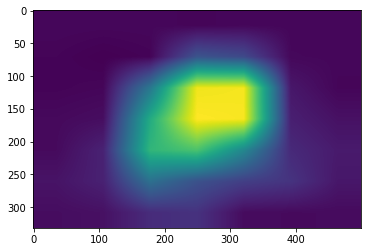

In [45]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

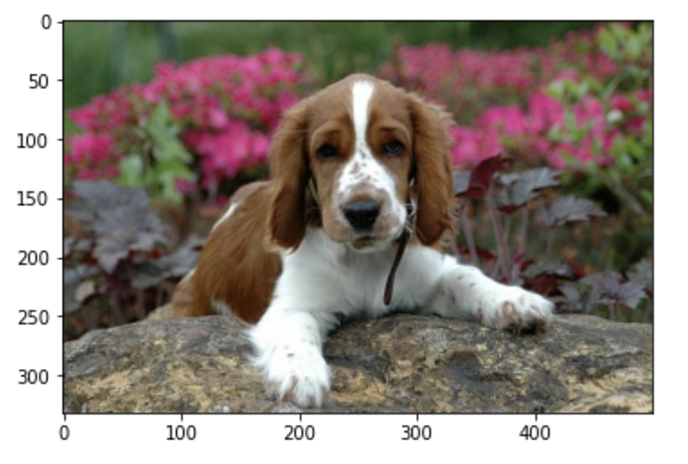

In [46]:
# Ïù¥Î†áÍ≤å Í∑∏Î†§ÏßÑ CAM Ïù¥ÎØ∏ÏßÄÎ•º ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÏôÄ Ìï©Ï≥ê Î¥ÖÏãúÎã§.
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

print('Ïäù=3')

Ïäù=3


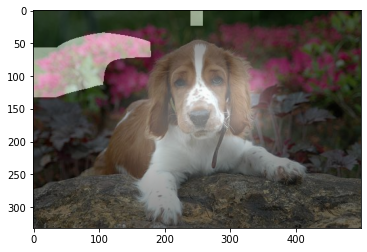

In [49]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

Ïñ¥Îñ§Í∞ÄÏöî? ÏÉùÏÑ±Îêú CAMÏù¥ Í∞úÎ•º ÏãùÎ≥ÑÌïòÎäîÎç∞ Ï§ëÏöîÌïú Ïù¥ÎØ∏ÏßÄ Î∂ÄÎ∂ÑÏùÑ Ïûò Ìè¨Ï∞©ÌïòÍ≥† ÏûàÎÇòÏöî? Ï£ºÎ°ú Í∞ïÏïÑÏßÄÏùò ÏñºÍµ¥Í≥º Î™∏ÌÜµÏù¥ ÏûàÎäî Î∂ÄÎ∂ÑÏù¥ Í∞ïÏ°∞ÎêòÎäî Í≤ΩÌñ•Ïù¥ ÏûàÎäîÎç∞, Ïù¥Í≤ÉÏùÄ ÏÇ¨ÎûåÏù¥ Í∞úÎ•º ÏãùÎ≥ÑÌï† Îïå Ïú†ÏùòÌï¥ÏÑú Î≥¥Îäî Î∂ÄÎ∂ÑÍ≥º ÏùºÎß•ÏÉÅÌÜµÌï©ÎãàÎã§.



### 8-7. Grad-CAM
Ïù¥Î≤àÏóêÎäî Grad-CAMÏùÑ Ïù¥Ïö©Ìï¥ÏÑú CAMÏùÑ ÏñªÏñ¥Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§. Ï†ÅÏö© Î™®Îç∏ÏùÑ Ïú†Ïó∞ÌïòÍ≤å ÏÑ†ÌÉùÌï† Ïàò ÏûàÎäî Grad-CAMÏùò ÌäπÏÑ± ÏÉÅ ÏúÑÏóêÏÑú ÎßåÎì§ÏóàÎçò Î™®Îç∏ÏùÑ Îã§Ïãú ÌôúÏö©Ìï¥ÎèÑ Í¥úÏ∞ÆÍ∏∞ ÎïåÎ¨∏Ïóê Í¥ÄÏ∞∞ ÎåÄÏÉÅ Î™®Îç∏ÏùÄ cam_modelÏùÑ Í∑∏ÎåÄÎ°ú ÌôúÏö©Ìï©ÏãúÎã§.

Ïö∞ÏÑ† ÏÉàÎ°úÏö¥ Ïù¥ÎØ∏ÏßÄÎ•º ÎΩëÏïÑÎ¥ÖÏãúÎã§.






40


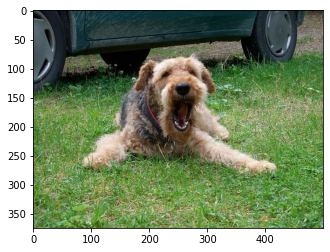

In [50]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

Ïù¥Î≤àÏóêÎäî Grad-CAMÏùÑ Ïù¥Ïö©Ìï¥ÏÑú CAMÏùÑ ÎßåÎì§Ïñ¥ Î¥ÖÏãúÎã§.

grad_camÏùÄ Í¥ÄÏ∞∞ÏùÑ ÏõêÌïòÎäî Î†àÏù¥Ïñ¥ÏôÄ Ï†ïÎãµ ÌÅ¥ÎûòÏä§Ïóê ÎåÄÌïú ÏòàÏ∏°Í∞í ÏÇ¨Ïù¥Ïùò Í∑∏ÎûòÎîîÏñ∏Ìä∏Î•º Íµ¨ÌïòÍ≥†, Ïó¨Í∏∞Ïóê GAP Ïó∞ÏÇ∞ÏùÑ Ï†ÅÏö©Ìï®ÏúºÎ°úÏç® Í¥ÄÏ∞∞ ÎåÄÏÉÅÏù¥ ÎêòÎäî Î†àÏù¥Ïñ¥Ïùò Ï±ÑÎÑêÎ≥Ñ Í∞ÄÏ§ëÏπòÎ•º Íµ¨Ìï©ÎãàÎã§. ÏµúÏ¢Ö CAM Ïù¥ÎØ∏ÏßÄÎ•º Íµ¨ÌïòÍ∏∞ ÏúÑÌï¥ÏÑúÎäî Î†àÏù¥Ïñ¥Ïùò Ï±ÑÎÑêÎ≥Ñ Í∞ÄÏ§ëÏπò(weights)ÏôÄ Î†àÏù¥Ïñ¥ÏóêÏÑú ÎÇòÏò® Ï±ÑÎÑêÎ≥Ñ ÌäπÏÑ± ÎßµÏùÑ Í∞ÄÏ§ëÌï©Ìï¥Ï£ºÏñ¥ cam_imageÎ•º ÏñªÍ≤å Îê©ÎãàÎã§.

Ïù¥Ï†Ñ Ïä§ÌÖùÏóêÏÑú Î≥∏ CAM Ìï®ÏàòÏôÄ Îã¨Î¶¨, Grad-CAMÏùÄ Ïù¥Î≤àÏóêÎäî Ïñ¥Îñ§ Î†àÏù¥Ïñ¥Îì† CAM Ïù¥ÎØ∏ÏßÄÎ•º ÎΩëÏïÑÎÇº Ïàò ÏûàÏúºÎØÄÎ°ú, Í∑∏ÎûòÎîîÏñ∏Ìä∏ Í≥ÑÏÇ∞ÏùÑ ÏõêÌïòÎäî Í¥ÄÏ∞∞ ÎåÄÏÉÅ Î†àÏù¥Ïñ¥ activation_layerÎ•º ÎΩëÏïÑÏÑú Ïì∏ Ïàò ÏûàÎèÑÎ°ù activation_layerÏùò Ïù¥Î¶ÑÏùÑ Î∞õÍ≥† Ïù¥Î•º ÌôúÏö©Ìï¥Ïïº Ìï©ÎãàÎã§.

ÏïÑÎûò generate_grad_cam()ÏóêÏÑúÎäî ÏõêÌïòÎäî Î†àÏù¥Ïñ¥Ïùò outputÍ≥º ÌäπÏ†ï ÌÅ¥ÎûòÏä§Ïùò prediction ÏÇ¨Ïù¥Ïùò Í∑∏ÎûòÎîîÏñ∏Ìä∏ grad_valÏùÑ ÏñªÍ≥† Ïù¥Î•º weightsÎ°ú ÌôúÏö©Ìï©ÎãàÎã§.






In [60]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad camÏóêÏÑúÎèÑ camÍ≥º Í∞ôÏù¥ ÌäπÏ†ï Î†àÏù¥Ïñ¥Ïùò outputÏùÑ ÌïÑÏöîÎ°ú ÌïòÎØÄÎ°ú Î™®Îç∏Ïùò inputÍ≥º outputÏùÑ ÏÉàÎ°≠Í≤å Ï†ïÏùòÌï©ÎãàÎã§.
    # Ïù¥Îïå ÏõêÌïòÎäî Î†àÏù¥Ïñ¥Í∞Ä Îã§Î•º Ïàò ÏûàÏúºÎãà Ìï¥Îãπ Î†àÏù¥Ïñ¥Ïùò Ïù¥Î¶ÑÏúºÎ°ú Ï∞æÏùÄ ÌõÑ outputÏúºÎ°ú Ï∂îÍ∞ÄÌï©ÎãàÎã§.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    # Model ÌÅ¥ÎûòÏä§Îäî KerasÏùò Functional APIÎ•º ÏÇ¨Ïö©Ìï¥ ÏÉàÎ°úÏö¥ Î™®Îç∏ÏùÑ Ï†ïÏùò = KerasÏùò Model ÌÅ¥ÎûòÏä§Îäî ÏûÖÎ†• ÌÖêÏÑúÏôÄ Ï∂úÎ†• ÌÖêÏÑúÎ•º Í∏∞Î∞òÏúºÎ°ú ÏÉàÎ°úÏö¥ Î™®Îç∏ÏùÑ ÏÉùÏÑ±
    # activation_layerÎäî ÏÇ¨Ïö©ÏûêÍ∞Ä Grad-CAMÏóêÏÑú Ï£ºÎ™©ÌïòÍ≥† Ïã∂ÏùÄ Î†àÏù¥Ïñ¥Ïùò Ïù¥Î¶ÑÏùÑ ÏùòÎØ∏
    #	1.	activation_layerÏùò Ï∂úÎ†• ‚Üí Ïù¥ Î†àÏù¥Ïñ¥Ïùò Feature MapÏù¥ ÌïÑÏöîÌï©ÎãàÎã§.
    #   2.	Î™®Îç∏Ïùò ÏµúÏ¢Ö Ï∂úÎ†• ‚Üí Ïù¥ Í∞íÏúºÎ°úÎ∂ÄÌÑ∞ **Gradients (Í∏∞Ïö∏Í∏∞)**Î•º Íµ¨Ìï¥Ïïº Ìï©ÎãàÎã§.
    
    
    # GradientÎ•º ÏñªÍ∏∞ ÏúÑÌï¥ tapeÎ•º ÏÇ¨Ïö©Ìï©ÎãàÎã§. with Î∏îÎ°ù ÏïàÏóê ÏûëÏÑ±Îêú Ïó∞ÏÇ∞Îì§Ïóê ÎåÄÌïú **Í∏∞Ïö∏Í∏∞(gradient)**Î•º Ï∂îÏ†Å
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
        # grad_modelÏùò Ï∂úÎ†•ÏùÄ Feature MapÍ≥º ÏµúÏ¢Ö ÏòàÏ∏°Í∞í(pred=Softmax Î†àÏù¥Ïñ¥Î•º Í±∞Ïπú ÌÅ¥ÎûòÏä§Î≥Ñ ÏòàÏ∏°Í∞í)ÏûÖÎãàÎã§.
        loss = pred[:, class_idx] # ÏõêÌïòÎäî class(Ïó¨Í∏∞ÏÑúÎäî Ï†ïÎãµÏúºÎ°ú ÌôúÏö©) ÏòàÏ∏°Í∞íÏùÑ ÏñªÏäµÎãàÎã§.
        output = conv_output[0] # ÏõêÌïòÎäî layerÏùò outputÏùÑ ÏñªÏäµÎãàÎã§. 
        grad_val = tape.gradient(loss, conv_output)[0] # ÏòàÏ∏°Í∞íÏóê Îî∞Î•∏ LayerÏùò gradientÎ•º ÏñªÏäµÎãàÎã§.
        # lossÏóê ÎåÄÌï¥ conv_output(Feature Map)Ïùò **Í∏∞Ïö∏Í∏∞(gradient)**Î•º Í≥ÑÏÇ∞
        # Ïù¥ Í∏∞Ïö∏Í∏∞Îäî Í∞Å Feature Map Ï±ÑÎÑêÏù¥ Ìï¥Îãπ ÌÅ¥ÎûòÏä§Ïóê ÏñºÎßàÎÇò Í∏∞Ïó¨ÌñàÎäîÏßÄ ÎÇòÌÉÄÎÉÑ
        
    weights = np.mean(grad_val, axis=(0, 1)) # gradientÏùò GAPÏúºÎ°ú weightÎ•º Íµ¨Ìï©ÎãàÎã§.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # outputÏùò kÎ≤àÏß∏ Ï±ÑÎÑêÍ≥º kÎ≤àÏß∏ weightÎ•º Í≥±ÌïòÍ≥† ÎàÑÏ†ÅÌï¥ÏÑú class activation mapÏùÑ ÏñªÏäµÎãàÎã§.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

""" loss = pred[:, class_idx]
    pred = [0.1, 0.9]  # Í∞ïÏïÑÏßÄÏùº ÌôïÎ•†: 10%, Í≥†ÏñëÏù¥Ïùº ÌôïÎ•†: 90%
	‚Ä¢	class_idx: Grad-CAMÏù¥ ÏßëÏ§ëÌïòÍ≥† Ïã∂ÏùÄ ÌÅ¥ÎûòÏä§Ïùò Ïù∏Îç±Ïä§ÏûÖÎãàÎã§.
    ÏòàÎ•º Îì§Ïñ¥, class_idx = 1Ïù¥Î©¥ Í≥†ÏñëÏù¥Ïóê Ìï¥ÎãπÌïòÎäî ÌÅ¥ÎûòÏä§ÏûÖÎãàÎã§.
	‚Ä¢	pred[:, class_idx]:
	‚Ä¢	ÏõêÌïòÎäî ÌÅ¥ÎûòÏä§ **class_idx**Ïóê ÎåÄÌïú ÌôïÎ•†Í∞íÏùÑ ÏùòÎØ∏Ìï©ÎãàÎã§.
	‚Ä¢	ÏòàÎ•º Îì§Ïñ¥:
	‚Ä¢	pred = [0.1, 0.9]Ïù¥Í≥† class_idx = 1Ïù¥Î©¥ pred[:, class_idx] = 0.9ÏûÖÎãàÎã§.
    
    *** Ï§ëÏöî
    ‚Ä¢	Ïù¥Îïå LossÎ•º Ìï¥Îãπ ÌÅ¥ÎûòÏä§Ïùò ÌôïÎ•†Í∞íÏúºÎ°ú ÏÑ§Ï†ïÌïòÎ©¥:
	‚Ä¢	Î™®Îç∏Ïù¥ ÏòàÏ∏°Ìïú ÌÅ¥ÎûòÏä§ ÌôïÎ•†Ïù¥ ÎÜíÏùÑÏàòÎ°ù Ìï¥Îãπ ÌÅ¥ÎûòÏä§Ïóê Îçî Ïûò ÏòàÏ∏°Ìïú Í≤ÉÏûÖÎãàÎã§.
	‚Ä¢	Ïù¥ ÌôïÎ•†Í∞íÏóê Îî∞Î•∏ **Gradient(Í∏∞Ïö∏Í∏∞)**Î•º Í≥ÑÏÇ∞ÌïòÎ©¥,
        Î™®Îç∏Ïù¥ Ïñ¥Îñ§ Feature Map Ï±ÑÎÑêÏù¥ Ìï¥Îãπ ÌÅ¥ÎûòÏä§ ÏòàÏ∏°Ïóê Ï§ëÏöîÌïú Í∏∞Ïó¨Î•º ÌñàÎäîÏßÄ Ïïå Ïàò ÏûàÏäµÎãàÎã§.
"""

""" output = conv_output[0]
	‚Ä¢	conv_outputÏùÄ Feature MapÏù¥ Î∞∞Ïπò Îã®ÏúÑÎ°ú Î∞òÌôòÎêú ÌòïÌÉúÏûÖÎãàÎã§.
	‚Ä¢	conv_output[0]ÏùÑ ÌÜµÌï¥ Ï≤´ Î≤àÏß∏ Ïù¥ÎØ∏ÏßÄÏùò Feature MapÎßå ÏÑ†ÌÉùÌï©ÎãàÎã§.
	‚Ä¢	ÏòàÎ•º Îì§Ïñ¥, conv_outputÏù¥ (1, 7, 7, 2048)ÎùºÎ©¥ conv_output[0]ÏùÄ (7, 7, 2048)ÏûÖÎãàÎã§.
"""

# print('Ïäù=3')

' output = conv_output[0]\n\t‚Ä¢\tconv_outputÏùÄ Feature MapÏù¥ Î∞∞Ïπò Îã®ÏúÑÎ°ú Î∞òÌôòÎêú ÌòïÌÉúÏûÖÎãàÎã§.\n\t‚Ä¢\tconv_output[0]ÏùÑ ÌÜµÌï¥ Ï≤´ Î≤àÏß∏ Ïù¥ÎØ∏ÏßÄÏùò Feature MapÎßå ÏÑ†ÌÉùÌï©ÎãàÎã§.\n\t‚Ä¢\tÏòàÎ•º Îì§Ïñ¥, conv_outputÏù¥ (1, 7, 7, 2048)ÎùºÎ©¥ conv_output[0]ÏùÄ (7, 7, 2048)ÏûÖÎãàÎã§.\n'

Q. ÏúÑ ÏΩîÎìúÏóêÏÑú with tf.GradientTape() as tape: Î•º ÏÇ¨Ïö©ÌïòÎäî Ïù¥Ïú†Î•º ÏÉùÍ∞ÅÌï¥Î¥ÖÏãúÎã§.

  
Grad-CAMÏóêÏÑú ÏõêÌïòÎäî Î†àÏù¥Ïñ¥Ïùò outputÍ≥º ÌäπÏ†ï ÌÅ¥ÎûòÏä§Ïùò prediction ÏÇ¨Ïù¥Ïùò Í∑∏ÎûòÎîîÏñ∏Ìä∏ grad_valÏùÑ ÏñªÍ≥† Ïù¥Î•º weightsÎ°ú ÌôúÏö©ÌïòÍ∏∞ ÎïåÎ¨∏ÏûÖÎãàÎã§.  

Ïù¥Ï†ú ÎßåÎì† Ìï®ÏàòÎ°ú Ïó¨Îü¨ Î†àÏù¥Ïñ¥Ïùò CAM Ïù¥ÎØ∏ÏßÄÎ•º ÎΩëÏïÑÏÑú ÏßÅÏ†ë ÌôïÏù∏Ìï¥Î≥¥ÏÑ∏Ïöî! Î†àÏù¥Ïñ¥Ïùò Ïù¥Î¶ÑÏùÄ Ïù¥Ï†Ñ Ïä§ÌÉ≠Ïùò cam_model.summary() Í≤∞Í≥ºÏóêÏÑú Ï∞æÏùÑ Ïàò ÏûàÏäµÎãàÎã§.


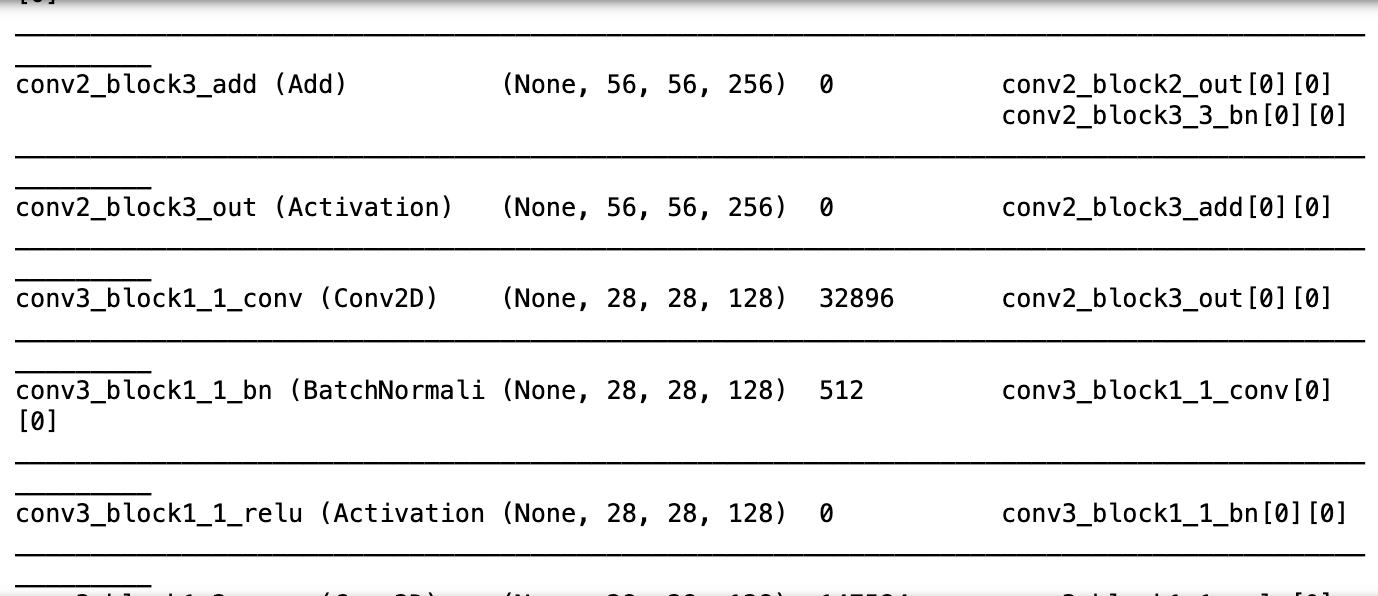




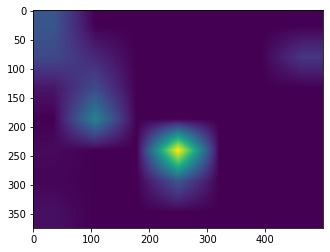

In [61]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

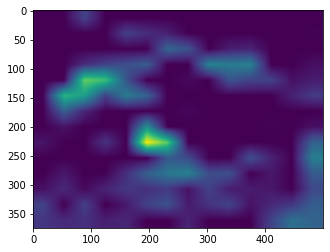

In [62]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

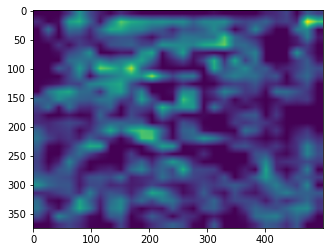

In [63]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

###  8-8. Detection with CAM
Î∞îÏö¥Îî© Î∞ïÏä§
ÎßàÏßÄÎßâÏúºÎ°ú Ïù¥Î≤àÏóêÎäî CAMÏóêÏÑú Î¨ºÏ≤¥Ïùò ÏúÑÏπòÎ•º Ï∞æÎäî detectionÏùÑ Ìï¥ Î≥¥ÎèÑÎ°ù ÌïòÍ≤†ÏäµÎãàÎã§.

Ïö∞ÏÑ† ÏÉàÎ°úÏö¥ Ïù¥ÎØ∏ÏßÄÎ•º Îã§Ïãú ÎΩëÏïÑ CAM Ïù¥ÎØ∏ÏßÄÎ•º ÎΩëÏïÑÎ¥ÖÏãúÎã§.

84


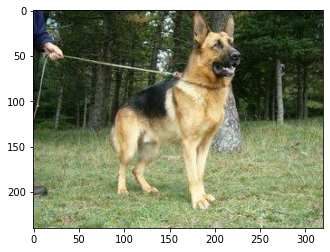

In [65]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

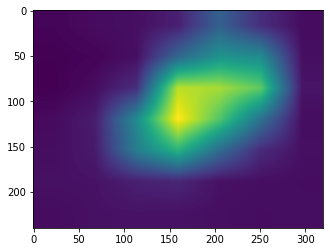

In [66]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

Ïù¥Ï†Ñ Ïä§ÌÖùÏóêÏÑú ÎßåÎì§ÏóàÎçò generate_cam()ÏùÑ ÌôúÏö©Ìï¥ÏÑú CAM Ïù¥ÎØ∏ÏßÄÎ•º ÎΩëÏïòÏäµÎãàÎã§. ÏïÑÎûò get_bbox() Ìï®ÏàòÎäî Î∞îÏö¥Îî© Î∞ïÏä§Î•º ÎßåÎì§Í∏∞ ÏúÑÌï¥ÏÑú score_threshÎ•º Î∞õÏïÑ Ïó≠ÏπòÍ∞í Ïù¥ÌïòÏùò Î∞îÏö¥Îî© Î∞ïÏä§Îäî ÏóÜÏï±ÎãàÎã§. Í∑∏ Îã§Ïùå OpenCVÏùò findContours()ÏôÄ minAreaRect()Î°ú ÏÇ¨Í∞ÅÌòïÏùÑ Ï∞æÏäµÎãàÎã§. Ïù¥Îïå rotated_rect ÎùºÎäî ÌöåÏ†ÑÎêú Î∞îÏö¥Îî© Î∞ïÏä§Î•º ÏñªÏùÑ Ïàò ÏûàÏäµÎãàÎã§. boxPoints()Î°ú Ïù¥Î•º Íº≠ÏßÄÏ†êÏúºÎ°ú Î∞îÍæ∏Ïñ¥ Ï§çÎãàÎã§. ÎßàÏßÄÎßâÏóêÎäî int ÏûêÎ£åÌòïÏúºÎ°ú Î≥ÄÌôòÌï¥ Ï§çÎãàÎã§.






In [68]:
# (CAM) Ïù¥ÎØ∏ÏßÄÏóêÏÑú Bounding Box(Í≤ΩÍ≥Ñ ÏÉÅÏûê)Î•º Ï∂îÏ∂úÌïòÎäî Ìï®Ïàò
# CAM Ïù¥ÎØ∏ÏßÄÏóêÏÑú ÌäπÏ†ï ÌÅ¥ÎûòÏä§Í∞Ä ÌôúÏÑ±ÌôîÎêú ÏòÅÏó≠ÏùÑ Í∏∞Ï§ÄÏúºÎ°ú Í≤ΩÍ≥Ñ ÏÉÅÏûêÎ•º Ï∞æÏïÑ Î∞òÌôò
def get_bbox(cam_image, score_thresh=0.05):
    # cam_image: CAM Ïù¥ÎØ∏ÏßÄ, Í∞íÏù¥ 0Í≥º 1 ÏÇ¨Ïù¥Ïùò ÌôúÏÑ±Ìôî Ï†êÏàòÎ•º Í∞ÄÏßÑ Ïù¥ÎØ∏ÏßÄ threshold 0.05(ÎÇÆÏùÄ ÌôúÏÑ±Ìôî) ÎØ∏Îßå Î¨¥Ïãú
    low_indicies = cam_image <= score_thresh
    # low_indicies: cam_imageÏóêÏÑú Ï†êÏàòÍ∞Ä score_thresh Ïù¥ÌïòÏù∏ ÌîΩÏÖÄÎì§Ïùò ÏúÑÏπò(Boolean Î∞∞Ïó¥)
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    # Í≤ÄÏ∂úÎêú Ï≤´ Î≤àÏß∏ ContourÎ•º ÏÑ†ÌÉù -> Ï≤´Î≤àÏß∏ contourÍ∞Ä Í∞ÄÏû• ÌÅ∞ ÌôúÏÑ±Ìôî ÏòÅÏó≠ÏûÑ
    rotated_rect = cv2.minAreaRect(cnt) # Ï£ºÏñ¥ÏßÑ contour Í∞êÏã∏Îäî Í∞ÄÏû• ÏûëÏùÄ ÌöåÏ†ÑÎêú ÏÇ¨Í∞ÅÌòï
    rect = cv2.boxPoints(rotated_rect) # Í≥°ÏßÄÏ†ê Íµ¨ÌïòÍ∏∞ 4Í∞ú Ï¢åÌëú
    rect = np.int0(rect) # Ï†ïÏàòÌòï Î≥ÄÌôò
    return rect # Ï¢åÌëú 4Í∞ú Î∞òÌôò 
"""
	‚Ä¢	cv2.findContours: Ïù¥ÎØ∏ÏßÄÏóêÏÑú **Contour(Í≤ΩÍ≥ÑÏÑ†)**Î•º Ï∞æÏïÑÏ£ºÎäî OpenCV Ìï®ÏàòÏûÖÎãàÎã§.
	‚Ä¢	cv2.RETR_TREE: Í≥ÑÏ∏µÏ†Å Íµ¨Ï°∞Î°ú Î™®Îì† ContourÎ•º Ï∞æÏïÑÎÉÖÎãàÎã§.
	‚Ä¢	cv2.CHAIN_APPROX_SIMPLE: ContourÎ•º Í∞ÑÏÜåÌôîÌï¥ Íº≠ÏßÄÏ†êÎßå Î∞òÌôòÌï©ÎãàÎã§.
	‚Ä¢	contours: Í≤ÄÏ∂úÎêú ContourÎì§Ïùò Î¶¨Ïä§Ìä∏ÏûÖÎãàÎã§. ÌôúÏÑ±Ìôî ÏòÅÏó≠Ïùò Í≤ΩÍ≥ÑÏÑ†ÏûÖÎãàÎã§.
	‚Ä¢	_: Í≥ÑÏ∏µ Íµ¨Ï°∞Î•º ÎÇòÌÉÄÎÇ¥ÏßÄÎßå Ïó¨Í∏∞ÏÑúÎäî ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÏúºÎØÄÎ°ú _Î°ú Î¨¥ÏãúÌï©ÎãàÎã§.
"""
print('Ïäù=3')

Ïäù=3


In [69]:
rect = get_bbox(cam_image)
rect

array([[ 69,   0],
       [294,   0],
       [294, 201],
       [ 69, 201]])

cam_imageÏóêÏÑú bboxÎ•º ÏñªÍ≥† Ïù¥Î•º Ïù¥ÎØ∏ÏßÄ ÏúÑÏóê ÏãúÍ∞ÅÌôîÌïú Î™®ÏäµÏùÑ Î≥º Ïàò ÏûàÏäµÎãàÎã§.






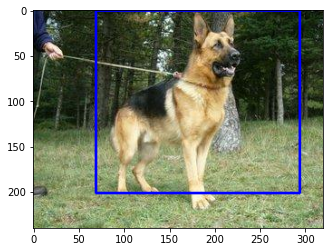

In [70]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### Intersection Over Union
ÏúÑÏóêÏÑú CAMÍ≥º Grad-CAM Îëê Í∞ÄÏßÄ Î∞©Î≤ïÏùÑ ÌÜµÌï¥ÏÑú Î∞îÏö¥Îî© Î∞ïÏä§Î•º ÏñªÏùÑ Ïàò ÏûàÏóàÏäµÎãàÎã§. Í∑∏Îüº Ï†ïÎãµ Îç∞Ïù¥ÌÑ∞Ïù∏ Î∞îÏö¥Îî© Î∞ïÏä§ÏôÄ Ïù¥Î•º Ïñ¥ÎñªÍ≤å ÎπÑÍµê, ÌèâÍ∞ÄÌï† Ïàò ÏûàÏùÑÍπåÏöî?

content img
IoU(Intersection over Union) Îäî Îëê ÏòÅÏó≠Ïùò ÍµêÏßëÌï©Ïù∏ intersection ÏòÅÏó≠Ïùò ÎÑìÏù¥Î•º Îëê ÏòÅÏó≠Ïùò Ìï©ÏßëÌï©Ïù∏ union ÏòÅÏó≠ÏúºÎ°ú ÎÇòÎàÑÏñ¥Ï§Ä Í∞íÏûÖÎãàÎã§. Ïù¥Î•º ÌÜµÌï¥ Ï∞æÍ≥†Ïûê ÌïòÎäî Î¨ºÍ±¥Ïùò Ï†àÎåÄÏ†ÅÏù∏ Î©¥Ï†ÅÍ≥º ÏÉÅÍ¥ÄÏóÜÏù¥, ÏòÅÏó≠ÏùÑ Ï†ïÌôïÌïòÍ≤å Ïûò Ï∞æÏïÑÎÇ¥ÏóàÎäîÏßÄÏùò ÏÉÅÎåÄÏ†ÅÏù∏ ÎπÑÏú®ÏùÑ Íµ¨Ìï† Ïàò ÏûàÏúºÎØÄÎ°ú, Î™®Îç∏Ïù¥ ÏòÅÏó≠ÏùÑ Ïûò Ï∞æÏïòÎäîÏßÄ ÎπÑÍµêÌïòÎäî Ï¢ãÏùÄ ÏßÄÌëúÍ∞Ä Îê©ÎãàÎã§.

#### Q. IoU(Intersection over Union)Ïùò Í≥ÑÏÇ∞ Ï†àÏ∞®Î•º Ï°∞ÏÇ¨ÌïòÍ≥†, ÌäπÏßïÏùÑ Ï†ïÎ¶¨Ìï¥Î≥¥ÏÑ∏Ïöî.


Ï≤´Î≤àÏß∏, Îëê Í∞úÏùò ÏòÅÏó≠ ÎòêÎäî Í∞ùÏ≤¥ Í∞ÑÏùò Í≤πÏπòÎäî Î∂ÄÎ∂ÑÏù∏ ÍµêÏ∞® ÏòÅÏó≠ÏùÑ Í≥ÑÏÇ∞Ìï©ÎãàÎã§. Ïù¥Îäî Îëê ÏòÅÏó≠Ïù¥ ÏñºÎßàÎÇò Í≤πÏπòÎäîÏßÄÎ•º ÎÇòÌÉÄÎÉÖÎãàÎã§. ÎëêÎ≤àÏß∏, Îëê Í∞úÏùò ÏòÅÏó≠ ÎòêÎäî Í∞ùÏ≤¥ Í∞ÑÏùò Ìï©ÏßëÌï© ÏòÅÏó≠ÏùÑ Í≥ÑÏÇ∞Ìï©ÎãàÎã§. Ïù¥Îäî Îëê ÏòÅÏó≠Ïù¥ Ï†ÑÏ≤¥Ï†ÅÏúºÎ°ú ÏñºÎßàÎÇò ÎßéÏùÄ Í≥µÍ∞ÑÏùÑ Ï∞®ÏßÄÌïòÎäîÏßÄÎ•º ÎÇòÌÉÄÎÉÖÎãàÎã§. ÏÑ∏Î≤àÏß∏, IoUÎ•º Í≥ÑÏÇ∞ÌïòÍ∏∞ ÏúÑÌï¥ ÍµêÏ∞® ÏòÅÏó≠ÏùÑ Ìï©ÏßëÌï© ÏòÅÏó≠ÏúºÎ°ú ÎÇòÎàïÎãàÎã§.

IoUÎäî Î≥¥ÌÜµ 0Í≥º 1 ÏÇ¨Ïù¥Ïùò Í∞íÏùÑ Í∞ÄÏßÄÎ©∞, 1Ïóê Í∞ÄÍπåÏö∏ÏàòÎ°ù Îëê Í∞úÏùò ÏòÅÏó≠Ïù¥ ÏôÑÏ†ÑÌûà ÏùºÏπòÌïòÍ±∞ÎÇò Îß§Ïö∞ Ïú†ÏÇ¨Ìï®ÏùÑ ÎÇòÌÉÄÎÉÖÎãàÎã§. 0Ïóê Í∞ÄÍπåÏö∏ÏàòÎ°ù Îëê ÏòÅÏó≠Ïù¥ Í≤πÏπòÏßÄ ÏïäÍ±∞ÎÇò Îß§Ïö∞ Îã§Î•∏ ÏòÅÏó≠ÏûÑÏùÑ ÎÇòÌÉÄÎÉÖÎãàÎã§.






In [71]:
# rectÏùò Ï¢åÌëúÎäî (x, y) ÌòïÌÉúÎ°ú, bboxÎäî (y_min, x_min, y_max, x_max)Ïùò normalized ÌòïÌÉúÎ°ú Ï£ºÏñ¥ÏßëÎãàÎã§. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding boxÏùò y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding boxÏùò x_min
        rect[:,1].max()/float(image.shape[0]), #bounding boxÏùò y_max
        rect[:,0].max()/float(image.shape[1]) #bounding boxÏùò x_max
    ]
    return bbox

print('Ïäù=3')

Ïäù=3


In [72]:
# ÏúÑÏóêÏÑú Íµ¨ÌñàÎçò rectÎ•º minmax bbox ÌòïÌÉúÎ°ú ÏπòÌôòÌï¥ Î¥ÖÏãúÎã§.
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.0, 0.215625, 0.8375, 0.91875]

In [73]:
#Ïù¥ Îç∞Ïù¥ÌÑ∞Ïùò ground truth bboxÎ•º ÌôïÏù∏Ìï¥ Î¥ÖÏãúÎã§.
item['objects']['bbox']

array([[0.     , 0.23125, 0.925  , 0.73125]], dtype=float32)

Ïñ¥Îñ§Í∞ÄÏöî? CAM Ï∂îÎ°† Í≤∞Í≥ºÎ°ú ÏñªÏñ¥ÏßÑ bboxÍ∞Ä ground truth bboxÏôÄ ÎπÑÏä∑ÌïòÍ≤å ÏñªÏñ¥Ï°åÎÇòÏöî? Ïù¥ ÎëòÏù¥ ÏñºÎßàÎÇò Ïú†ÏÇ¨ÌïúÏßÄÎ•º IoUÎ•º Í≥ÑÏÇ∞Ìï¥ÏÑú ÌôïÏù∏Ìï¥ Î¥ÖÏãúÎã§.






In [74]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

# ÏòàÏãúÎ°ú ÏÉùÍ∞ÅÌï¥Î≥¥Í∏∞
# boxA = [2, 2, 5, 5] (y_min, x_min, y_max, x_max)
# boxB = [3, 3, 6, 6]
print('Ïäù=3')

Ïäù=3


In [75]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6619326890396472